# Problem Statement: 
We aim to solve 2D steady-state heat diffusion problems in homogeneous media using the Physics-Informed Neural Networks (PINN) approach of PDE solutions for temperature  over a rectangular domain.



### **Domain**:
$$ 
\Omega = \{ (x, y) \mid 0 \leq x \leq L_1, \, 0 \leq y \leq L_2 \}
$$



### **Governing Equation**:
$$ 
\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0, \quad \text{in } \Omega.
$$ 


### **Boundary Conditions**

**Dirichlet Boundary Conditions** (Prescribed temperature on the top and right boundaries:  

   $$ 
   T(x, L_2) = T_0 \: cos \left(\frac{\pi x}{6a}\right), \quad \forall x \in [0, L_1].
   $$

   $$ 
   T(L_1, y) = 0, \quad \forall y \in [0, L_2].
   $$

**Neumann Boundary Conditions** (No flux on the right and bottom boundaries):  
   $$ 
   \frac{\partial T}{\partial y}(x, 0) = 0, \quad \forall x \in [0, L_1].
   $$
  
   $$ 
   \frac{\partial T}{\partial x}(0,y) = 0, \quad \forall y \in [0, L_2].
   $$

Here, $L_1 = 3a$ and $L_2 = 2a$. We solve this problem using Physics-Informed Neural Networks (PINN) and compare it with the Analytical solution for this configuration.



---


**Developed by**:
Lal Mamud, Postdoc - Subsurface Modeler, Environmental Subsurface Science Group, Energy & Environment Division, Pacific Northwest National Laboratory, Richland, WA, USA.

Pratanu Roy, Staff Scientist, Atmospheric, Earth and Energy Division, Lawrence Livermore National Laboratory, California, USA
**Mentors**:
Maruti K. Mudunuru and Satish Karra


## 1. Import required Python libraries 

In [205]:
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## 2. Define Domain and Boundary Conditions, and Generate Collocation Points

In [206]:
xmin, xmax = 0.0, 3.0
ymin, ymax = 0.0 , 2.0

# Define the boundary conditions
dT_dx1 = 0             # at x = 0 for all y_b1, Neumann boundary at the left (kPa)  
T1 = 0             # at x = 1 for all y, Dirichlet boundary at the right (kPa)
dT_dy1 = 0           # at y = 0 for all x, Neumann boundary at the bottom (kPa)
T0 = 1.0           # at y = 1 for all x, Dirichlet boundary at the top (kPa)

# define the number of points on each boundary and 
N_b = 100          # Number of boundary condition points on each side.
N_r = 5_000        # Number of collocation points within the domain

# Number of collocation points in x and y 

nx = 31
ny = 21

#domain = random.uniform(key, shape=(nx,ny), dtype='float32',minval=xmin, maxval=xmax)

key = random.PRNGKey(42)

x = random.uniform(key, shape=(nx,), dtype='float32', minval=xmin, maxval=xmax)
y = random.uniform(key, shape=(ny,), dtype='float32', minval=ymin, maxval=ymax)

#x = jnp.linspace(xmin, xmax, nx)
#y = jnp.linspace(ymin, ymax, ny)

xp, yp = jnp.meshgrid(x, y)
colloc = jnp.stack([xp.flatten(), yp.flatten()], 1)

# xin = colloc[:,0]
# yin = colloc[:,1]

# Inputs for boundary condition

xl = jnp.stack([jnp.ones(ny)*xmin, y], 1)
xb = jnp.stack([x, jnp.ones(nx)*ymin], 1)
xr = jnp.stack([jnp.ones(ny)*xmax, y], 1)
xt = jnp.stack([x, jnp.ones(nx)*ymax], 1)

# Here is our initial guess of params:
#params = init_random_params(0.1, layer_sizes=layer_sizes)


In [207]:
# def plot_boundary_conditions(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c):
#     plt.figure(figsize=(5, 4), dpi=150)
    
#     # Calculate vmin and vmax based on all boundary condition values
#     all_bc_values = np.concatenate([bc_1, bc_2, bc_3, bc_4])
#     vmin, vmax = all_bc_values.min(), all_bc_values.max()
    
#     # Plot each set of boundary conditions with dynamic vmin and vmax
#     s = 10
#     scatter1 = plt.scatter(x_b1, y_b1, c=bc_1, marker='x', vmin=vmin, vmax=vmax, label='P[0,y]', cmap=cm.jet, s=s)
#     plt.scatter(x_b2, y_b2, c=bc_2, marker='^', vmin=vmin, vmax=vmax, label='P[1,y]', cmap=cm.jet, s=s)
#     plt.scatter(x_b3, y_b3, c=bc_3, marker='*', vmin=vmin, vmax=vmax, label='$\\partial P/\\partial y[x,0]$', cmap=cm.jet, s=s)
#     plt.scatter(x_b4, y_b4, c=bc_4, marker='o', vmin=vmin, vmax=vmax, label='$\\partial P/\\partial y[x,1]$', cmap=cm.jet, s=s)
    
#     # Plot collocation points
#     s = 5
#     plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.5, label='Collocation points', s=s)
    
#     # Labels and colorbar
#     plt.xlabel('$X$')
#     plt.ylabel('$Y$')
#     cbar = plt.colorbar(scatter1, aspect=30)  # Attach colorbar to the first scatter plot
#     cbar.set_label('$temperature (kPa)$')
    
#     # Place the legend outside the plot
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)
#     plt.tight_layout()

# Call the updated function
# plot_boundary_conditions(x_b1, y_b1, bc_1, x_b2, y_b2, bc_2, x_b3, y_b3, bc_3, x_b4, y_b4, bc_4, x_c, y_c)

## 3. Define PDE Residual

In [208]:
# ∂^2T/∂x^2 + ∂^2T/∂y^2 = 0 
def pde_residual_2d_darcy(x,y,T):
    """
    Compute the PDE residual for the 2D Laplace equation.
    
    Inputs:
    x, y: Coordinates of collocation points (N x 1).
    P: Lambda function representing the neural network solution P(x, y).
    
    Output:
    Residual of the PDE at the collocation points (N x 1).
    """
    T_x = lambda x,y:jax.grad(lambda x,y:jnp.sum(T(x,y)),0)(x,y)
    T_xx = lambda x,y:jax.grad(lambda x,y:jnp.sum(T_x(x,y)),0)(x,y)
    
    T_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(T(x,y)),1)(x,y)
    T_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(T_y(x,y)),1)(x,y)

    bc_left = T_x(xl[:,[0]],xl[:,[1]]).reshape(-1,1)  # insulated
    bc_right = T(xr[:,[0]],xr[:,[1]]).reshape(-1,1) # equal to zero at solution
    bc_bottom = T_y(xb[:,[0]],xb[:,[1]]).reshape(-1,1) # insulated
    bc_top = T(xt[:,[0]],xt[:,[1]]).reshape(-1,1) - T0*jnp.cos(jnp.pi*xt[:,0]/6.0).reshape(-1,1)  # T0 = 1.0
    
    return T_xx(x,y) + T_yy(x,y), bc_left, bc_right, bc_bottom, bc_top

## 4. Define Neural Network Architecture

In [209]:
#Define Neural Network Architecture 
def neural_net(params, x, y):
    """
    Forward pass of a neural network to predict P(x, y).
    
    Inputs:
    params: Neural network parameters (list of weights and biases).
    x, y: Input coordinates (N x 1).
    
    Output:
    Predicted P(x, y) values (N x 1).
    """
    #print(np.shape(x), np.shape(y))
    X = jnp.concatenate([x, y],axis=1)
    *hidden,last = params
    for layer in hidden :
        X = jax.nn.tanh(X@layer['W']+layer['B'])
    return X@last['W'] + last['B']


# def neural_net(params, x, y):
#   # A multi-layer perceptron, i.e. a fully-connected neural network.
#   inputs = jnp.array([x,y])
#   for w, b in params:
#     outputs = jnp.dot(inputs, w) + b  # Linear transform
#     inputs = jnp.tanh(outputs) 
#   return outputs


# Function to initialize parameters of the neural network (weights and biases)
def init_params(layers):
    """
    Initialize parameters (weights and biases) for a neural network with specified layers.
    
    Args:
        layers: List of integers representing the number of nodes in each layer.
                For example, [2, 20, 20, 1] creates a network with input layer (2 nodes),
                two hidden layers (20 nodes each), and an output layer (1 node).
    
    Returns:
        params: List of dictionaries containing 'W' (weights) and 'B' (biases) for each layer.
    """
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)  # Generate random keys for each layer
    params = list()  # Initialize a list to store layer parameters
    
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):  # Loop through layer dimensions
        lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in))  # Xavier initialization bounds
        W = lb + (ub - lb) * jax.random.uniform(key, shape=(n_in, n_out))  # Initialize weights
        B = jax.random.uniform(key, shape=(n_out,))  # Initialize biases
        params.append({'W': W, 'B': B})  # Append layer parameters (weights and biases) to the list
    
    return params  # Return the initialized parameters

## 5. Define Loss Function

In [210]:
@jax.jit
def loss_fun(params, colloc):
    """
    Calculate the total loss for the PINN.
    
    Inputs:
        params: Neural network parameters (list of weights and biases).
        colloc: Collocation points for the PDE residual (N x 2).
        conds: Boundary condition data (list of 4 elements, one for each BC).
    
    Output:
        Scalar total loss value.
    """
    x_c, y_c = colloc[:, [0]], colloc[:, [1]]
    #print(np.shape(x_c))
    #print(np.shape(y_c))
    
    T_nn = lambda x, y: neural_net(params, x, y)
    
    pde_residual, bc_left, bc_right, bc_bottom, bc_top = pde_residual_2d_darcy(x_c, y_c, T_nn)
    pde_loss = jnp.mean(pde_residual**2)
    bc_loss = jnp.mean(bc_left**2) + jnp.mean(bc_right**2) + jnp.mean(bc_bottom**2) + jnp.mean(bc_top**2)
    # Loss at the left and right Dirichlet BCs 
    # dbc_loss = 0
    # for cond in conds[0:2]:
    #     x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]  
    #     #dbc_loss += MSE(P_nn(x_b, y_b), u_b)  # Dirichlet BC loss
    #     dbc_loss += jnp.mean(P_nn(x_b, y_b) - u_b)**2  # Dirichlet BC loss
    
    # # Loss at the bottom and top Neumann BCs 
    # nbc_loss = 0
    # P_nn_y = lambda x, y: jax.grad(lambda x, y: jnp.sum(P_nn(x, y)), 1)(x, y)  # Neumann BCs derivative
    # for cond in conds[2:4]:
    #     x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]  
    #     #nbc_loss += MSE(P_nn_y(x_b, y_b), u_b)  # Neumann BC loss
    #     nbc_loss += jnp.mean(P_nn_y(x_b, y_b) - u_b)**2  # Neumann BC loss
    
    # Total loss (summed components)
    #loss = pde_loss + dbc_loss + nbc_loss
    loss = pde_loss + bc_loss
    
    return loss

## 6. Define Hyperparameters and Training Loop
This cell contains the training loop for the Physics-Informed Neural Network (PINN). It includes functions and code to update the network parameters, compute the loss, track training progress, and identify the best-performing model during the training process.

In [211]:
# Define hyperparameters for the neural network and training
hidden_nodes = 20      # Number of nodes in each hidden layer
hidden_layers = 3      # Number of hidden layers in the neural network
lr = 1e-3              # Learning rate for the optimizer
epochs = 5000          # Number of epochs for training


# Construct the MLP (Multilayer Perceptron) using the specified architecture
params = init_params([2] + [hidden_nodes] * hidden_layers + [1])  
# The network has 2 input nodes, `hidden_layers` layers with `hidden_nodes`, and 1 output node.

# Define the optimizer (Adam optimizer with the specified learning rate)
optimizer = optax.adam(lr)

# Initialize the optimizer state using the network parameters
opt_state = optimizer.init(params)


# Parameters update function
@jax.jit
def update(opt_state,params,colloc):
    """
    Perform a single optimization step:
    - Calculate gradients of the loss with respect to network parameters.
    - Update the parameters using the optimizer.
    
    Inputs:
    opt_state: Current optimizer state.
    params: Current neural network parameters (weights and biases).
    colloc: Collocation points for the PDE residual loss.
    conds: Boundary condition data for Dirichlet and Neumann conditions.
    
    Outputs:
    opt_state: Updated optimizer state.
    params: Updated network parameters.
    """
    # Get the gradient w.r.t to MLP params
    #grads=jax.jit(jax.grad(loss_fun,0))(params,colloc)
    value, grads = jax.value_and_grad(loss_fun)(params, colloc)
    
    #Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params


#%% PINN training loop
print('PINN training started...')

# Initialize tracking variables
best_params = params
best_loss = float('inf')
best_epoch = 0

# Initialize lists to track all losses and epochs
all_losses = []
all_epochs = []

# Training loop
for epoch in range(epochs+1):
    # Update the optimizer state and parameters
    opt_state, params = update(opt_state, params, colloc)

    # Calculate the current loss
    current_loss = loss_fun(params, colloc)
    
    # Store loss and epoch
    all_losses.append(current_loss)
    all_epochs.append(epoch)
    
    # Update the best parameters if the current loss is the lowest
    if current_loss < best_loss:
        best_loss = current_loss
        best_params = params
        best_epoch = epoch

    # Print loss and epoch info
    if epoch % 100 == 0:
        print(f'Epoch={epoch}\tloss={current_loss:.3e}')

print('PINN training done!')
print(f'Best Epoch = {best_epoch}\tBest Loss = {best_loss:.3e}')

PINN training started...
Epoch=0	loss=2.186e+00
Epoch=100	loss=8.620e-02
Epoch=200	loss=5.571e-02
Epoch=300	loss=2.521e-02
Epoch=400	loss=9.143e-03
Epoch=500	loss=4.448e-03
Epoch=600	loss=2.528e-03
Epoch=700	loss=1.567e-03
Epoch=800	loss=1.071e-03
Epoch=900	loss=8.009e-04
Epoch=1000	loss=6.343e-04
Epoch=1100	loss=5.167e-04
Epoch=1200	loss=4.265e-04
Epoch=1300	loss=3.551e-04
Epoch=1400	loss=2.979e-04
Epoch=1500	loss=2.519e-04
Epoch=1600	loss=2.148e-04
Epoch=1700	loss=1.846e-04
Epoch=1800	loss=1.598e-04
Epoch=1900	loss=1.393e-04
Epoch=2000	loss=1.221e-04
Epoch=2100	loss=1.076e-04
Epoch=2200	loss=9.526e-05
Epoch=2300	loss=8.471e-05
Epoch=2400	loss=7.562e-05
Epoch=2500	loss=6.775e-05
Epoch=2600	loss=6.089e-05
Epoch=2700	loss=5.488e-05
Epoch=2800	loss=4.958e-05
Epoch=2900	loss=4.488e-05
Epoch=3000	loss=4.069e-05
Epoch=3100	loss=3.693e-05
Epoch=3200	loss=3.355e-05
Epoch=3300	loss=3.048e-05
Epoch=3400	loss=2.771e-05
Epoch=3500	loss=2.519e-05
Epoch=3600	loss=2.290e-05
Epoch=3700	loss=2.082e-05

## 7. Plot pinn loss during training

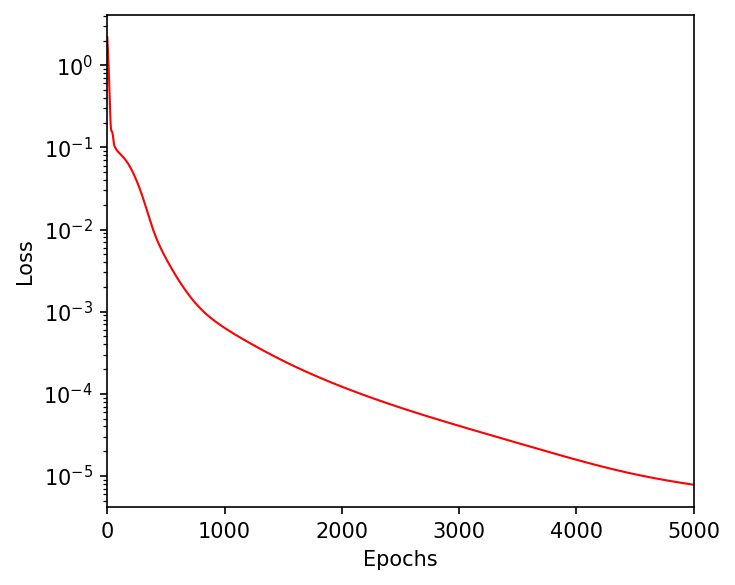

In [212]:
#function for plotting for PINN losses during training 
def plot_pinn_training(all_losses, all_epochs):
    plt.figure(figsize = (5, 4), dpi = 150)
    plt.semilogy(all_epochs, all_losses, '-r', markersize = 4, linewidth = 1.0)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.legend(prop={"size": fontsize_legend}, loc="best")
    plt.xlim(min(all_epochs), max(all_epochs))
    plt.tight_layout()
    
plot_pinn_training(all_losses, all_epochs)

## 8. PINN prediction and plotting results

In [230]:
#%% PINN prediction and plotting results
nx = 20
x = np.linspace(xmin, xmax, nx)
dx = x[1] - x[0]
ny = 20
y = np.linspace(ymin, ymax, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)
print(np.shape(X), np.shape(Y))
pinn_T = (neural_net(best_params, X.flatten().reshape(-1,1), Y.flatten().reshape(-1,1))).reshape(nx,ny) 
print(np.shape(pinn_T))
#print(pinn_T)

(20, 20) (20, 20)
(20, 20)


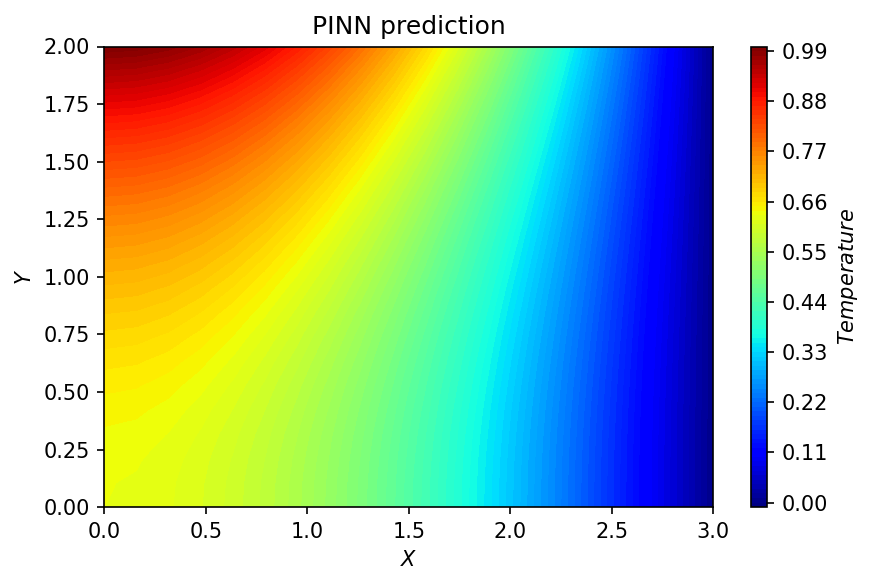

In [231]:
def plot_2d_temperature_distribution(X, Y, temperature, title, cbar_lebel):
    plt.figure(figsize = (6, 4), dpi = 150)
    cmap = 'jet'
    contour = plt.contourf(X, Y, temperature, levels=100, cmap=cmap)  
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    # Colorbar settings
    vmin = np.min(temperature)
    vmax = np.max(temperature)
    #cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin = vmin, vmax = vmax), cmap=cm.jet), aspect=30)
    cbar = plt.colorbar(contour, aspect=30)


    cbar.set_label(f'{cbar_lebel}')
    plt.xlim(np.min(X), np.max(X))
    plt.ylim(np.min(Y), np.max(Y))
    plt.title(title)
    plt.tight_layout()

title = "PINN prediction"
cbar_lebel = "$Temperature$"
plot_2d_temperature_distribution(X, Y, pinn_T, title, cbar_lebel)

## 9. Solution verifications

In [232]:
#%% Analytical solution
def f_exact(x,y):
   return (jnp.cosh(jnp.pi*y/6.0)*jnp.cos(jnp.pi*x/6.0))/jnp.cosh(jnp.pi/3.0)

analytical_T = f_exact(X,Y)
#print(analytical_P)

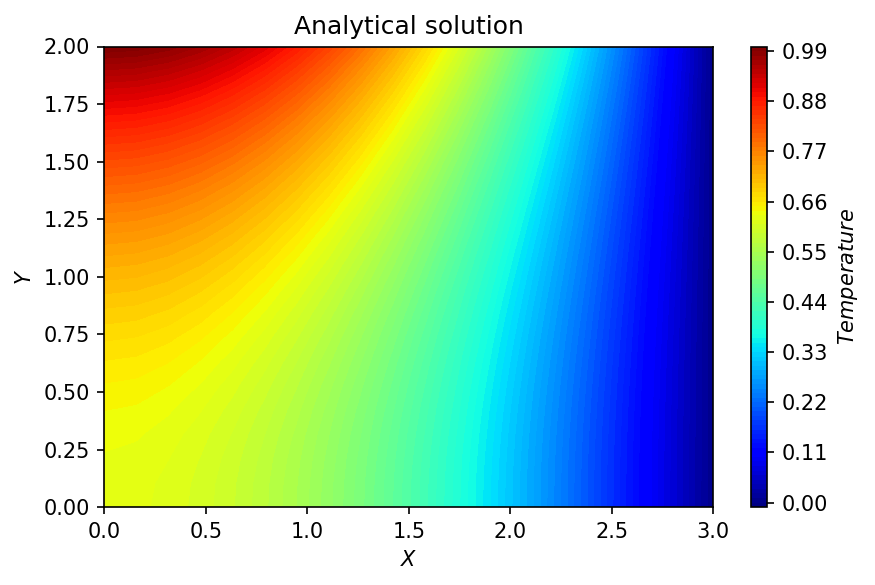

In [236]:
title = "Analytical solution"
cbar_lebel = "$Temperature$"
plot_2d_temperature_distribution(X, Y, analytical_T, title, cbar_lebel)

## 10. Error analysis between the analytical solution and PINN prediction

(400, 1) (400, 1)
R^2 Score: 1.0000
Root Mean Squared Error (RMSE): 0.0013


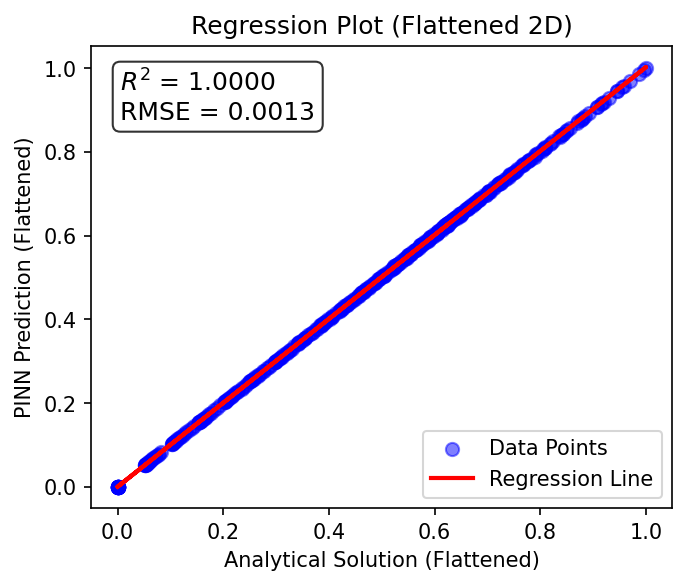

In [237]:
# Flatten the 2D arrays into 1D
analytical_Tr = analytical_T.flatten().reshape(-1, 1)  # Flatten to 1D and reshape to 2D (n_samples, n_features)
pinn_Tr = pinn_T.flatten().reshape(-1, 1)                       # Flatten to 1D (n_samples,)

print(np.shape(analytical_Tr), np.shape(pinn_Tr))
# Perform regression
reg = LinearRegression()
reg.fit(analytical_Tr, pinn_Pr)  # Fit the model

# Predict using the regression model
y_pred = reg.predict(analytical_Tr)

# Calculate R^2 score
r2 = r2_score(pinn_Tr, y_pred)

# Calculate RMSE
mse = mean_squared_error(pinn_Tr, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Erro

# Print results
print(f"R^2 Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

#%% Plotting Regression
plt.figure(figsize=(5, 4), dpi = 150)
plt.scatter(analytical_Tr, pinn_Tr, label="Data Points", color="blue", alpha=0.5, s=40)
plt.plot(analytical_Tr, y_pred, label="Regression Line", color="red", linewidth=2)

# Add annotations for RMSE and R^2
plt.text(
    0.05,
    0.95,
    f"$R^2$ = {r2:.4f}\nRMSE = {rmse:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.xlabel("Analytical Solution (Flattened)")
plt.ylabel("PINN Prediction (Flattened)")
plt.title("Regression Plot (Flattened 2D)")
plt.legend(loc="lower right")

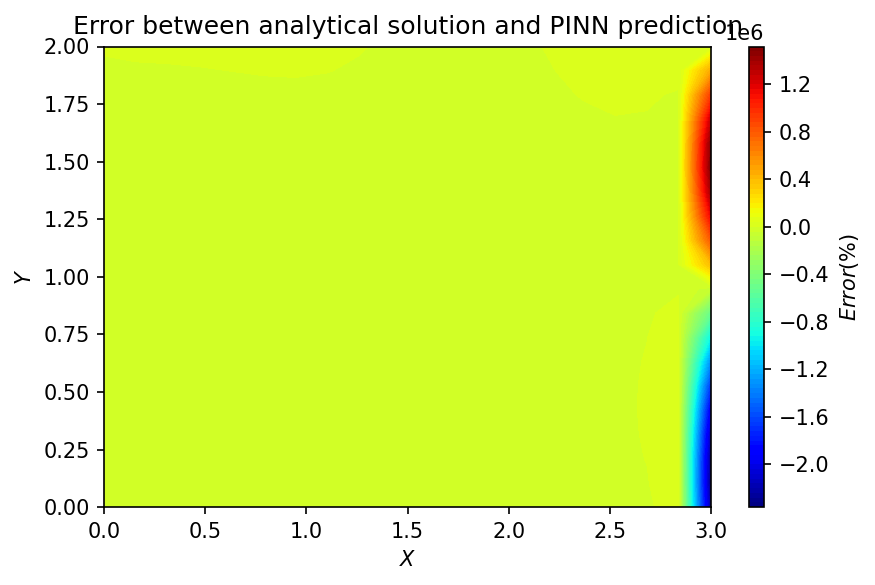

In [238]:
# Plot the percentage error
error_percentage = 100 * (analytical_T - pinn_T) / (analytical_T)
title = "Error between analytical solution and PINN prediction"
cbar_lebel = "$Error (\%)$"
plot_2d_temperature_distribution(X, Y, error_percentage, title, cbar_lebel)